In [6]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp
from hyperopt.pyll.base import scope
from hyperopt import STATUS_OK
import ipynb.fs.full.utils as utils
import ipynb.fs.full.features as features
import ipynb.fs.full.features_distancias as f_distancias


df_train = pd.read_csv('./data/train_filtrado.csv')
# Para usarse con el submit a Kaggle
df_eval = pd.read_csv('./data/test.csv')

df_train_idf = pd.read_csv('./data/train_idf.csv')
df_eval_idf = pd.read_csv('./data/test_idf.csv')

df_train = pd.merge(df_train, df_train_idf, on= 'id', how= 'left')
df_eval = pd.merge(df_eval, df_eval_idf, on= 'id', how= 'left')

df_train_idf = pd.read_csv('./data/train_idf.csv')
df_test_idf = pd.read_csv('./data/test_idf.csv')

df_train = pd.merge(df_train, df_train_idf, on= 'id', how= 'left')
df_eval = pd.merge(df_eval, df_test_idf, on= 'id', how= 'left')

df_train, df_test = utils.dividir_df_testeo(df_train, test_size=0.01)

df_eval = features.llenar_nulls(df_eval, hgb_mean=True, df_fill=df_train)
df_train = features.llenar_nulls(df_train, hgb_mean=True)

In [7]:
# df_train = df_train.sample(frac=1).reset_index(drop=True)

df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=100, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=100, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', df_aux=df_test_f)


df_train_f['fecha'] = pd.to_datetime(df_train_f['fecha']).astype(int)
df_test_f['fecha'] = pd.to_datetime(df_test_f['fecha']).astype(int)

# df_train_f = df_train_f.sample(frac=1).reset_index(drop=True)

df_train_f = f_distancias.feature_distancias(df_train_f)
df_test_f = f_distancias.feature_distancias(df_test_f, df_train_f)

df_train_f = features.rankings(df_train_f, df_train_f)
df_test_f = features.rankings(df_test_f, df_train_f)

## Búsqueda hiperparámetros

### RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV


features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'fecha', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'clustering_label', 'idf_titulo',
       'idf_descripcion', 'peso_titulo', 'peso_descripcion',
       'porcentaje_metros', 'diferencia_metros', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'escomercial',
       'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad',
       'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
       'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'mes', 'dia', 'trimestre',
       'dias_desde_datos', 'meses_desde_datos', 'antiguedad_bins_perc',
       'cantidad_inquilinos', 'tam_ambientes', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'promedio_id_zona_gen', 'varianza_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad',
       'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes',
       'promedio_precio_habitaciones',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad',
       'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje',
       'distancia_ciudad_centrica', 'distancia_centro_mexico',
       'distancia_ciudad_cara']

lgb_params = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['mae'], # Si se deja vacio se toma el ideal para llegar al 'objective'
    'bagging_fraction': [0.1, 0.3, 0.5, 0.7, 0.9],
    'bagging_freq': [0, 1, 5, 10, 20, 40],
    'min_data_in_leaf': [10, 20, 40],
    'max_bin': [100, 175, 255, 364, 512],
    'reg_lambda': [0, 2, 6, 10, 15, 30, 40, 50],
    'min_split_gain': [0, 0.05, 0.1, 0.2, 0.4, 0.8],
    'feature_fraction': [0.85],
    'max_depth': [5, 10, 15],
    'num_leaves': [200, 300, 500],
    'learning_rate': [0.1, 0.15, 0.2, 0.25],
    'n_jobs': [4]
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=1)

rs_cv = RandomizedSearchCV(estimator=lgb.LGBMRegressor(),
                           param_distributions=lgb_params, 
                           cv=3, 
                           n_iter=200,
                           verbose=3, scoring='neg_mean_absolute_error')

rs_cv.fit(x_train, y_train, verbose=1)

In [110]:
display(rs_cv.best_params_)
from sklearn.externals import joblib
# Guarda el modelo
joblib.dump(rs_cv, 'lightgbm_rscv.pkl', compress=1)

{'reg_lambda': 50,
 'objective': 'regression',
 'num_leaves': 500,
 'n_jobs': 4,
 'min_split_gain': 0.4,
 'min_data_in_leaf': 20,
 'metric': 'mae',
 'max_depth': 15,
 'max_bin': 512,
 'learning_rate': 0.2,
 'feature_fraction': 0.85,
 'boosting_type': 'gbdt',
 'bagging_freq': 0,
 'bagging_fraction': 0.7}

['lightgbm_rscv.pkl']

In [111]:
results = pd.DataFrame(rs_cv.cv_results_).sort_values('rank_test_score')

In [113]:
results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_reg_lambda', 'param_objective', 'param_num_leaves',
       'param_n_jobs', 'param_min_split_gain', 'param_min_data_in_leaf',
       'param_metric', 'param_max_depth', 'param_max_bin',
       'param_learning_rate', 'param_feature_fraction', 'param_boosting_type',
       'param_bagging_freq', 'param_bagging_fraction', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [121]:
results[['param_reg_lambda', 'param_objective', 'param_num_leaves',
       'param_n_jobs', 'param_min_split_gain', 'param_min_data_in_leaf',
       'param_metric', 'param_max_depth', 'param_max_bin',
       'param_learning_rate', 'param_feature_fraction', 'param_boosting_type',
       'param_bagging_freq', 'param_bagging_fraction', 
       'mean_test_score']].head(10)

,param_reg_lambda,param_objective,param_num_leaves,param_n_jobs,param_min_split_gain,param_min_data_in_leaf,param_metric,param_max_depth,param_max_bin,param_learning_rate,param_feature_fraction,param_boosting_type,param_bagging_freq,param_bagging_fraction,mean_test_score
9,50,regression,500,4,0.4,20,mae,15,512,0.2,0.85,gbdt,0,0.7,-480406.611583
77,30,regression,200,4,0.1,40,mae,15,512,0.15,0.85,gbdt,0,0.5,-482503.440834
133,6,regression,300,4,0.05,20,mae,10,175,0.15,0.85,gbdt,0,0.3,-483192.294021
100,15,regression,500,4,0.4,40,mae,10,255,0.15,0.85,gbdt,0,0.9,-483630.679354
147,10,regression,500,4,0.1,40,mae,15,255,0.2,0.85,gbdt,0,0.3,-483736.677475
76,40,regression,500,4,0.8,10,mae,15,255,0.2,0.85,gbdt,5,0.9,-484013.665572
199,15,regression,300,4,0.8,20,mae,10,364,0.1,0.85,gbdt,0,0.5,-484401.033139
27,6,regression,500,4,0.1,10,mae,10,255,0.15,0.85,gbdt,10,0.9,-484500.612984
26,2,regression,300,4,0.1,20,mae,10,255,0.15,0.85,gbdt,40,0.9,-484933.363759
98,40,regression,200,4,0.2,40,mae,15,255,0.15,0.85,gbdt,20,0.9,-485521.775079


### GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'fecha', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'clustering_label', 'idf_titulo',
       'idf_descripcion', 'peso_titulo', 'peso_descripcion',
       'porcentaje_metros', 'diferencia_metros', 'metros_totales_normalizados',
       'metros_cubiertos_normalizados', 'escomercial',
       'promedio_metros_tipo_propiedad', 'promedio_metros_cub_tipo_propiedad',
       'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
       'promedio_metros_totales_provincia',
       'promedio_metros_cubiertos_provincia', 'mes', 'dia', 'trimestre',
       'dias_desde_datos', 'meses_desde_datos', 'antiguedad_bins_perc',
       'cantidad_inquilinos', 'tam_ambientes', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'promedio_id_zona_gen', 'varianza_id_zona',
       'count_id_zona', 'promedio_precio_tipo_propiedad',
       'promedio_precio_tipo_propiedad_ciudad',
       'promedio_precio_tipo_propiedad_ciudad_gen', 'count_tipo_propiedad',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes', 'varianza_por_mes',
       'promedio_precio_habitaciones',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_banos_garages', 'promedio_precio_hbg_tipo_propiedad',
       'lat_norm', 'lng_norm', 'promedio_precio_booleanos', 'puntaje',
       'distancia_ciudad_centrica', 'distancia_centro_mexico',
       'distancia_ciudad_cara']


lgb_params = {
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['mae'], # Si se deja vacio se toma el ideal para llegar al 'objective'
#     'bagging_fraction': [0.1, 0.3, 0.5, 0.7, 0.9],
#     'bagging_freq': [0, 1, 5, 10, 20, 40],
#     'min_split_gain': [0, 0.1, 0.5],
    'min_child_weight': [120, 170, 230],
    'min_data_in_leaf': [10, 20, 40],
#     'max_bin': [100, 175, 255],
    'reg_lambda': [10, 15, 30],
    'feature_fraction': [0.7, 0.9],
    'max_depth': [10, 6],
    'num_leaves': [500, 300, 200],
    'learning_rate': [0.25],
    'n_jobs': [4]
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=1)

gs_cv = GridSearchCV(estimator=lgb.LGBMRegressor(), 
                           param_grid=lgb_params, 
                           cv=4,
                           verbose=3, scoring='neg_mean_absolute_error')

gs_cv.fit(x_train, y_train, verbose=1)

In [14]:
display(gs_cv.best_params_)
from sklearn.externals import joblib
# Guarda el modelo
joblib.dump(gs_cv, 'lightgbm_gscv_6.pkl', compress=1)

{'boosting_type': 'gbdt',
 'feature_fraction': 0.8,
 'learning_rate': 0.25,
 'max_bin': 255,
 'max_depth': 15,
 'metric': 'mae',
 'min_data_in_leaf': 40,
 'min_split_gain': 0,
 'n_jobs': 4,
 'num_leaves': 200,
 'objective': 'regression',
 'reg_lambda': 10}

['lightgbm_gscv_5.pkl']

In [80]:
results = pd.DataFrame(gs_cv.cv_results_).sort_values('rank_test_score')

In [81]:
results[['param_boosting_type',
'param_feature_fraction',
'param_min_child_weight',
'mean_test_score', 'rank_test_score']].head(10)

,param_boosting_type,param_feature_fraction,param_min_child_weight,mean_test_score,rank_test_score
162,gbdt,0.9,120,-486042.607841,1
171,gbdt,0.9,120,-486042.607841,1
180,gbdt,0.9,120,-486042.607841,1
166,gbdt,0.9,120,-486187.310235,4
175,gbdt,0.9,120,-486187.310235,4
184,gbdt,0.9,120,-486187.310235,4
167,gbdt,0.9,120,-486210.902933,7
176,gbdt,0.9,120,-486210.902933,7
185,gbdt,0.9,120,-486210.902933,7
182,gbdt,0.9,120,-486263.851105,10


In [56]:
results['param_reg_lambda'].value_counts()

10    216
6     216
2     216
0     216
Name: param_reg_lambda, dtype: int64

### hyperopt

In [ ]:
from sklearn.model_selection import cross_val_score

features =['habitaciones', 
            'garages', 
            'banos',
            'antiguedad',
           'metroscubiertos', 
            'metrostotales',
            'lat_norm', 'lng_norm'
            'gimnasio', 'usosmultiples', 'piscina','prop_frecuente', 'top_provincia', 'promedio_precio_ciudad', 
                 'anio', 'promedio_id_zona', 'promedio_precio_tipo_propiedad', 
                 'count_id_zona', 'count_ciudad', 'puntaje', 
                     'count_tipo_propiedad_ciudad', 
                 'promedio_precio_tipo_propiedad_ciudad_gen',
                 'count_id_zona'
                 'dias_desde_datos',
                 'meses_desde_datos',
                 'porcentaje_metros',
                 'distancia_ciudad_centrica']

def eval_lightgbm(params):
    
    return {'loss': -np.average(cross_val_score(lgb.LGBMRegressor(**params), 
                                                utils.filtrar_features(df_train_f, features).values, df_train_f['precio'].values, cv=3, scoring='neg_mean_absolute_error')),
            'status': STATUS_OK}

space = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae', # Si se deja vacio se toma el ideal para llegar al 'objective'
#     'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 1),
#     'bagging_freq': hp.choice('bagging_freq', [0, 1, 5, 10, 20, 40]),
#     'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 1),
    'bagging_freq': hp.choice('bagging_freq', [0]),
    'min_data_in_leaf': scope.int(hp.quniform('min_data_in_leaf', 5, 95, 1)),
    'max_bin': scope.int(hp.quniform('max_bin', 64, 2014, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 0, 75),
    'min_split_gain': hp.uniform('min_split_gain', 0, 1),
    'feature_fraction': 0.85,
    'max_depth': scope.int(hp.quniform('max_depth', 3, 25, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 100, 800, 1)),
    'learning_rate': 0.15,
    'n_jobs': 4
}

hps = fmin(eval_lightgbm, space=space, algo=tpe.suggest, max_evals=200, verbose=1)

display(hps)

## Evaluación features

In [ ]:
features += features_test

features += cols_tipodepropiedad_ohe + cols_provincia_ohe + cols_zona_ohe

features_remove = [['lat', 'lng'], ['antiguedad'], ['habitaciones'], ['garages'], ['banos'], ['metroscubiertos'], ['metrostotales'],
                   ['prop_frecuente'], ['top_provincia'], ['porcentaje_metros'], ['diferencia_metros'], 
                   ['promedio_precio_ciudad'],  ['promedio_por_mes'], ['anio'], ['promedio_id_zona'], ['promedio_id_zona_log'],
                   ['promedio_id_zona', 'promedio_id_zona_log'], ['promedio_precio_tipo_propiedad'],  
                   ['promedio_precio_hbg_tipo_propiedad'], ['count_id_zona'], ['count_ciudad'], 
                   ['puntaje'],  ['count_tipo_propiedad'], ['count_tipo_propiedad_ciudad'],  
                   ['promedio_precio_tipo_propiedad_ciudad_gen'], ['promedio_precio_hbg_tipo_propiedad_provincia'], 
                   ['varianza_id_zona'], ['tam_ambientes'], ['metros_cubiertos_normalizados'], ['dias_desde_datos'], 
                   ['meses_desde_datos']]

hps = {'bagging_fraction': 0.806451877022587,
 'bagging_freq': 62.0,
 'feature_fraction': 0.5379925983440028,
 'learning_rate': 0.1363027714646826,
 'max_depth': 11.0,
 'num_leaves': 113.0,
 'test_size': 0.09575190901892519}

bagging_fraction = hps['bagging_fraction']
bagging_freq = int(hps['bagging_freq'])
feature_fraction = hps['feature_fraction']
learning_rate = hps['learning_rate']
num_leaves = int(hps['num_leaves'])
max_depth = int(hps['max_depth'])
test_size = hps['test_size']

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'mae'}, # Si se deja vacio se toma el ideal para llegar al 'objective'
    'num_leaves': num_leaves,
    'learning_rate': learning_rate,
    'feature_fraction': feature_fraction,
    'bagging_fraction': bagging_fraction,
    'bagging_freq': bagging_freq,
    'max_depth': max_depth,
    'verbose': 0
}


base_train = 0
base_test = 0
base_eval = 0
for i in [['None']] + features_remove:
    
    features_new = [f for f in features if f not in i]
    if len(features_new) == len(features) and i != ['None']:
        print(f'{i} no encontrado')
        conitnue
    
    x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features_new, test_size=test_size)

    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_eval,
                    num_boost_round=1000,
                    early_stopping_rounds=15,
                    verbose_eval=-1)

    y_pred_test = gbm.predict(x_test, raw_score=True, num_iteration=gbm.best_iteration)
    y_pred_train = gbm.predict(x_train, raw_score=True, num_iteration=gbm.best_iteration)
    y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features_new), num_iteration=gbm.best_iteration)

    gbm_mae_train = utils.MAE(y_train, y_pred_train)
    gbm_mae = utils.MAE(y_test, y_pred_test)
    gbm_mae_eval = utils.MAE(df_test_f['precio'].values, y_pred_eval)

    print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
    print(f"MAE LightGBM (test): {gbm_mae:.5f}")
    print(f"MAE LightGBM (eval): {gbm_mae_eval:.5f}")
    if i != ['None']:
        print(f"Overfitting (base_eval - base_test) - (eval - test) - {i}: {(base_eval - base_test) - (gbm_mae_eval - gbm_mae)}")
        print(f"Diff evaluation (base_eval - eval)                  - {i}: {base_eval - gbm_mae_eval}")
        print(f"Diff train (base_train - train)                     - {i}: {base_train - gbm_mae_train}")
    else:
        base_train = gbm_mae_train
        base_test = gbm_mae
        base_eval = gbm_mae_eval

## Evaluación modelo final

In [ ]:
features = ['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos',
       'metrostotales', 'lat', 'lng', 'fecha', 'piscina',
       'clustering_label', 'idf_descripcion',
       'porcentaje_metros', 'diferencia_metros', 'promedio_metros_tipo_propiedad', 
       'prop_frecuente', 'top_provincia', 'es_ciudad_centrica',
       'mes', 'trimestre', 'dias_desde_datos',
       'tam_ambientes', 'promedio_precio_provincia',
       'promedio_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'count_id_zona', 'promedio_precio_tipo_propiedad',
       'promedio_precio_tipo_propiedad_ciudad', 'count_tipo_propiedad',
       'count_tipo_propiedad_ciudad', 'promedio_por_mes',
       'promedio_precio_habitaciones_banos_garages',
       'promedio_precio_hbg_tipo_propiedad', 'puntaje',
       'distancia_ciudad_centrica', 'distancia_centro_mexico',
       'ranking_en_provincia_tipodepropiedad_precio',
       'ranking_en_provincia_tipodepropiedad_cantidad']

params = {'reg_lambda': 6,
'objective': 'regression',
'num_leaves': 300,
'n_jobs': 4,
'min_split_gain': 0.05,
'min_data_in_leaf': 20,
'metric': 'mae',
'max_depth': 10,
'max_bin': 175,
'learning_rate': 0.15,
'feature_fraction': 0.85,
'boosting_type': 'gbdt',
'bagging_freq': 0,
'bagging_fraction': 0.3}


x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=0.05)

gbm = lgb.LGBMRegressor(**params)

gbm.fit(x_train, y_train)

y_pred_test = gbm.predict(x_test)
y_pred_train = gbm.predict(x_train)

y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features))

df_test_f['target'] = y_pred_eval
# df_test_f = utils.pesificar_df(df_test_f, 'target', 'target')

gbm_mae_train = utils.MAE(y_train, y_pred_train)
gbm_mae = utils.MAE(y_test, y_pred_test)
gbm_mae_eval = utils.MAE(df_test_f['precio'].values, df_test_f['target'].values)

print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
print(f"MAE LightGBM (test): {gbm_mae:.5f}")cl
print(f"MAE LightGBM (eval): {gbm_mae_eval:.5f}")

In [4]:
import shap 
# shap.initjs()

df_test_shap = utils.filtrar_features(df_test_f, features)

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(df_test_shap)

In [5]:
# shap.force_plot(explainer.expected_value, shap_values, df_test_shap)

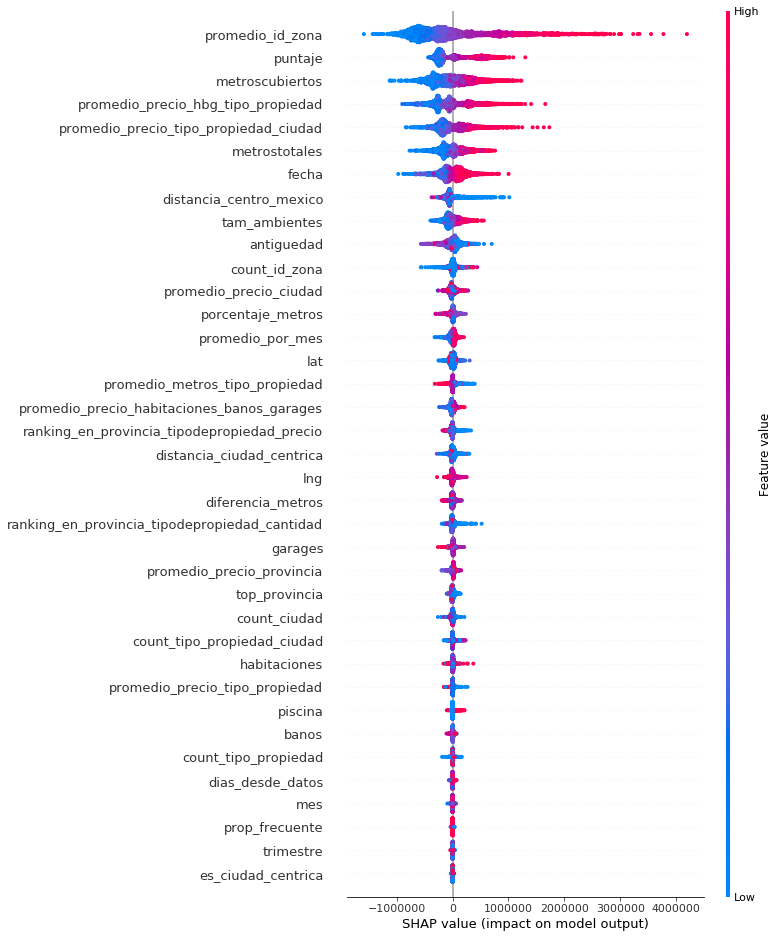

In [8]:
shap.summary_plot(shap_values, df_test_shap, max_display=50)

## Evaluación df_test completo

In [19]:
import ipynb.fs.full.features as features

df_train = pd.read_csv('./data/train.csv',)

# Para usarse con el submit a Kaggle
df_test = pd.read_csv('./data/test.csv')

df_test = features.llenar_nulls(df_test, hgb_mean=True)
df_train = features.llenar_nulls(df_train, hgb_mean=True)

df_test_f = features.features_independientes_precio(df_test)
df_test_f = features.features_dependientes_precio(df_test_f, df_train)

df_train_f = features.features_independientes_precio(df_train)
df_train_f = features.features_dependientes_precio(df_train_f, df_train)

df_test_f, cols_tipodepropiedad_ohe = features.columna_a_ohe(df_test_f, 'tipodepropiedad', N=250, df_aux=df_train, devolver_cols=True)
df_test_f, cols_provincia_ohe = features.columna_a_ohe(df_test_f, 'provincia', N=250, df_aux=df_train, devolver_cols=True)
df_test_f, cols_zona_ohe = features.columna_a_ohe(df_test_f, 'zona', N=250, df_aux=df_train_f, devolver_cols=True)

df_train_f = features.columna_a_ohe(df_train_f, 'tipodepropiedad', N=250, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'provincia', N=250, df_aux=df_test)
df_train_f = features.columna_a_ohe(df_train_f, 'zona', N=250, df_aux=df_test_f)

features =['antiguedad', 'garages', 'metroscubiertos', 'lng', 'fecha',
       'porcentaje_metros', 'dia', 'dias_desde_datos', 'tam_ambientes',
       'metros_totales_normalizados', 'varianza_precio_ciudad', 'count_ciudad',
       'promedio_id_zona', 'count_id_zona',
       'promedio_precio_tipo_propiedad_ciudad', 'count_tipo_propiedad_ciudad',
       'varianza_por_mes', 'promedio_precio_habitaciones_banos_garages',
       'lat_norm', 'puntaje', 'idf_titulo', 'idf_descripcion',
       'peso_descripcion', 'distancia_ciudad_centrica',
       'distancia_centro_mexico',
       'ranking_en_provincia_tipodepropiedad_precio',
       'ranking_en_provincia_tipodepropiedad_cantidad']


params = {
 'bagging_fraction': 0.7863825296731695,
 'bagging_freq': 0,
 'max_bin': 100,
 'max_depth': 15,
 'min_data_in_leaf': 20,
 'min_split_gain': 0.48874667957166357,
 'num_leaves': 486,
 'reg_lambda': 12.823774492528074,
 'boosting_type': 'gbdt',
 'metric': 'mae',
 'n_jobs': 4,
 'objective': 'regression',
 'n_estimators': 1500,
}

x_train, x_test, y_train, y_test = utils.dividir_dataset(df_train_f, 'precio', features, test_size=test_size)


lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

gbm = lgb.LGBMRegressor(**params)

gbm.fit(x_train, y_train, early_stopping_rounds=15, eval_set=[(x_test, y_test)])

y_pred_test = gbm.predict(x_test)
y_pred_train = gbm.predict(x_train)
y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features))

gbm_mae_train = utils.MAE(y_train, y_pred_train)
gbm_mae = utils.MAE(y_test, y_pred_test)

print(f"MAE LightGBM (train): {gbm_mae_train:.5f}")
print(f"MAE LightGBM (test): {gbm_mae:.5f}")

[1]	valid_0's l1: 1.45931e+06
Training until validation scores don't improve for 15 rounds
[2]	valid_0's l1: 1.34548e+06
[3]	valid_0's l1: 1.24499e+06
[4]	valid_0's l1: 1.15628e+06
[5]	valid_0's l1: 1.07789e+06
[6]	valid_0's l1: 1.00927e+06
[7]	valid_0's l1: 948672
[8]	valid_0's l1: 895597
[9]	valid_0's l1: 849121
[10]	valid_0's l1: 807902
[11]	valid_0's l1: 772001
[12]	valid_0's l1: 741137
[13]	valid_0's l1: 713824
[14]	valid_0's l1: 690089
[15]	valid_0's l1: 668864
[16]	valid_0's l1: 650487
[17]	valid_0's l1: 634267
[18]	valid_0's l1: 619933
[19]	valid_0's l1: 607483
[20]	valid_0's l1: 596856
[21]	valid_0's l1: 587083
[22]	valid_0's l1: 578579
[23]	valid_0's l1: 571273
[24]	valid_0's l1: 564674
[25]	valid_0's l1: 558723
[26]	valid_0's l1: 553512
[27]	valid_0's l1: 548801
[28]	valid_0's l1: 544646
[29]	valid_0's l1: 540988
[30]	valid_0's l1: 537531
[31]	valid_0's l1: 534412
[32]	valid_0's l1: 531942
[33]	valid_0's l1: 529689
[34]	valid_0's l1: 527284
[35]	valid_0's l1: 525246
[36]	val

[312]	valid_0's l1: 479950
[313]	valid_0's l1: 479932
[314]	valid_0's l1: 479897
[315]	valid_0's l1: 479872
[316]	valid_0's l1: 479845
[317]	valid_0's l1: 479850
[318]	valid_0's l1: 479795
[319]	valid_0's l1: 479741
[320]	valid_0's l1: 479737
[321]	valid_0's l1: 479685
[322]	valid_0's l1: 479666
[323]	valid_0's l1: 479647
[324]	valid_0's l1: 479581
[325]	valid_0's l1: 479550
[326]	valid_0's l1: 479489
[327]	valid_0's l1: 479455
[328]	valid_0's l1: 479446
[329]	valid_0's l1: 479351
[330]	valid_0's l1: 479348
[331]	valid_0's l1: 479334
[332]	valid_0's l1: 479314
[333]	valid_0's l1: 479354
[334]	valid_0's l1: 479367
[335]	valid_0's l1: 479405
[336]	valid_0's l1: 479389
[337]	valid_0's l1: 479397
[338]	valid_0's l1: 479370
[339]	valid_0's l1: 479404
[340]	valid_0's l1: 479372
[341]	valid_0's l1: 479350
[342]	valid_0's l1: 479329
[343]	valid_0's l1: 479275
[344]	valid_0's l1: 479234
[345]	valid_0's l1: 479210
[346]	valid_0's l1: 479193
[347]	valid_0's l1: 479180
[348]	valid_0's l1: 479152
[

In [ ]:
y_pred_eval = gbm.predict(utils.filtrar_features(df_test_f, features))
df_test_f['target'] = y_pred_eval

df_test_f[['id', 'target']].to_csv('respuesta25.csv', index=False)